In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

#   Class Bandit 

- I use four functions the first ( init ) as a constructor for our Bandit, and the second (reset) for initialization of some parameters and the third ( act ) for game methods and the last ( step) for updating the estimation.

In [1]:
class Bandit:

    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.alpha = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.C = UCB_param
        self.grad = gradient
        self.grad_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.eps = epsilon
        self.initial = initial

    def reset(self):
        
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # number of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.eps:
            return np.random.choice(self.indices)

        if self.C is not None:
            UCB_estimation = self.q_estimation + \
                self.C * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.grad:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.grad:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.grad_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.alpha * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.alpha * (reward - self.q_estimation[action])
        return reward

# The game

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

# Simulation 1: Greedy and $\varepsilon$-Greedy Action 

##### Here wa simulate three agents each one uses our method:

- the first one use the greedy-action in which our agent will choose at each step the action which maximizes the estimate of the action value.
- The other two agents use method generate a Bernoulli law of parameter $\varepsilon$ after it will play what is called $\varepsilon$-greedy action. and we will compare the performance of each of these methods.
- for the two agents we use $\varepsilon$=0.1 and $\varepsilon$=0.01.

In [4]:
def sample_average(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon = eps, sample_averages = True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)
    
    return {"best_action_counts": best_action_counts, "rewards": rewards}

In [5]:
data0 = sample_average()

100%|██████████| 2000/2000 [01:11<00:00, 28.07it/s]


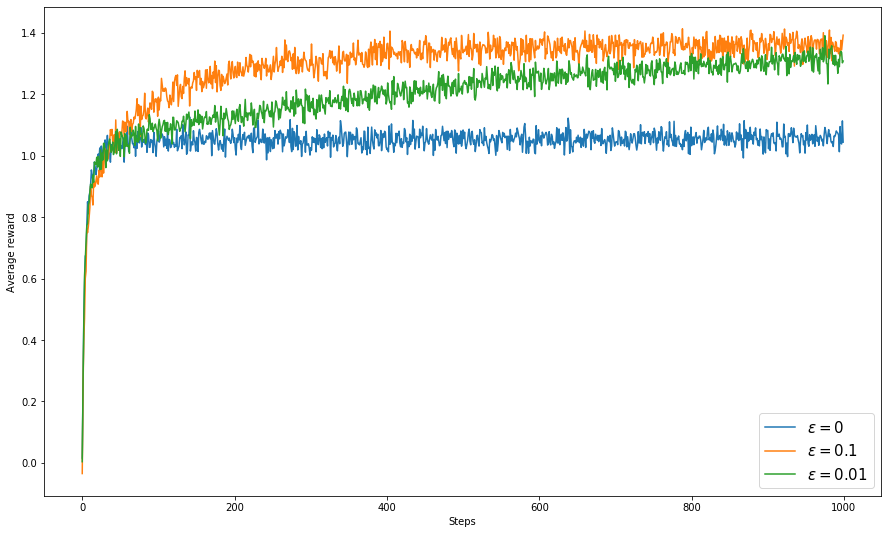

In [9]:
epsilons = [0, 0.1, 0.01]
rewards = data0["rewards"]
plt.figure(figsize=(15, 9))

for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label = r'$\varepsilon = '+ str(eps) + '$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend(loc='lower right', fontsize=15)


plt.show()

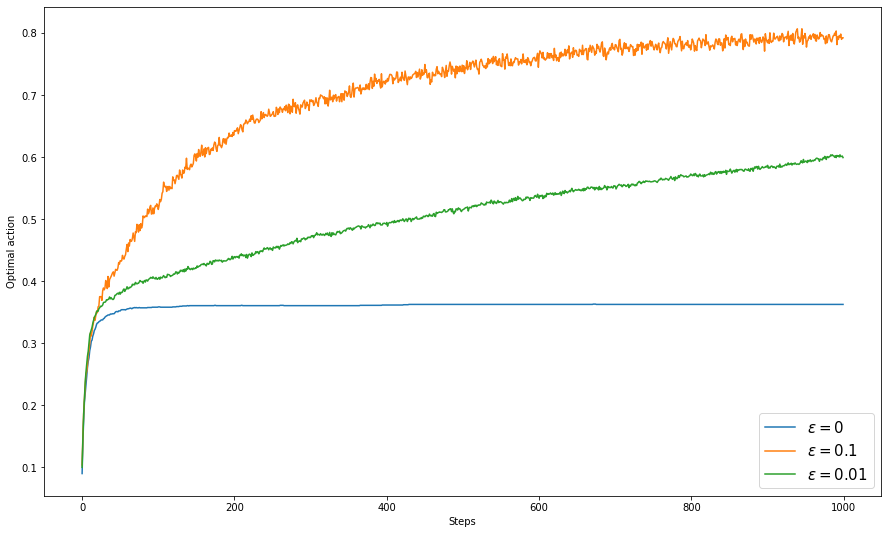

In [10]:
best_action_counts = data0["best_action_counts"]
epsilons = [0, 0.1, 0.01]
plt.figure(figsize=(15, 9))
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label = r'$\varepsilon = '+ str(eps) + '$')
plt.xlabel('Steps')
plt.ylabel('Optimal action')
plt.legend(loc='lower right', fontsize=15)

plt.show()

# Simulation 2 : Optimistic initial Value
- Here we will keep same method the greedy-action and we will change the initial value of our estimate for an agent or optimism we will initialize our estimate by a value of +5. and we compare their behavior of their performance with an agent who uses the realistic initial value.

In [9]:
def optimistic_initial_values(runs = 2000, time = 1000):
    bandits = []
    bandits.append(Bandit(epsilon = 0, initial = 5, step_size = 0.1))
    bandits.append(Bandit(epsilon = 0.1, initial = 0, step_size = 0.1))
    best_action_counts, _ = simulate(runs, time, bandits)
    return best_action_counts

In [10]:
data1 = optimistic_initial_values()
data1

100%|██████████| 2000/2000 [01:05<00:00, 30.56it/s]


array([[0.105 , 0.094 , 0.1035, ..., 0.863 , 0.8615, 0.861 ],
       [0.1095, 0.1395, 0.1755, ..., 0.774 , 0.77  , 0.766 ]])

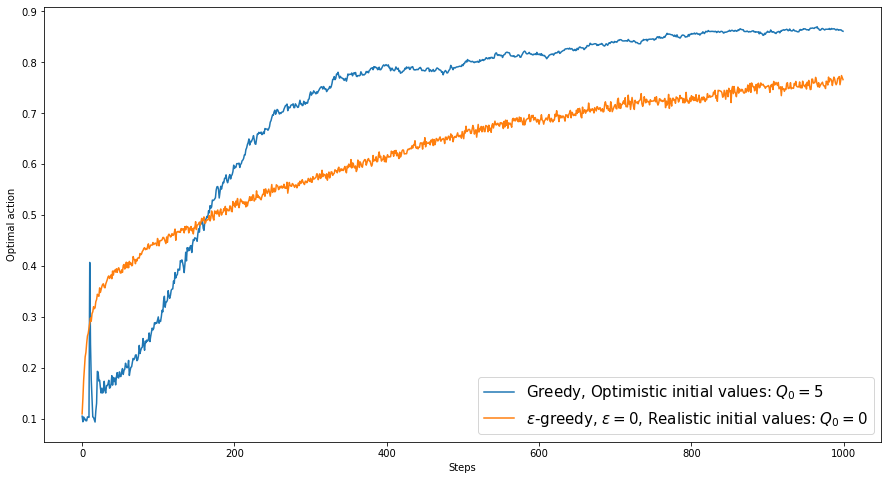

In [29]:
plt.figure(figsize = (15, 8))
plt.plot(data1[0], label = r'Greedy, Optimistic initial values: $Q_0 = 5$')
plt.plot(data1[1], label = (r'$\varepsilon$-greedy, $\varepsilon = ' + '0' + '$, Realistic initial values: $Q_0 = 0$'))
plt.xlabel('Steps')
plt.ylabel('Optimal action')
plt.legend(loc = 'lower right', fontsize = 15)

plt.show()

# Simulation 3 : Upper Confidence Bound 
- Here we are going to use two completely different agents in their game method.
- the first one will use the previous method $\varepsilon$-Greedy action with $\varepsilon$ = 0.1
- the second use a new method (UCB) in which we will define a confidence interval for the action value and we choose the best in this interval.




In [13]:
def UCB(runs=2000, time=1000):
    bandits = []
    
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)
    
    return average_rewards

In [14]:
data2 = UCB()
data2

100%|██████████| 2000/2000 [01:13<00:00, 27.27it/s]


array([[ 0.04974768,  0.03251478,  0.04240254, ...,  1.45380974,
         1.48876597,  1.4874851 ],
       [-0.01896784,  0.25103822,  0.40500221, ...,  1.36651635,
         1.34569991,  1.36297878]])

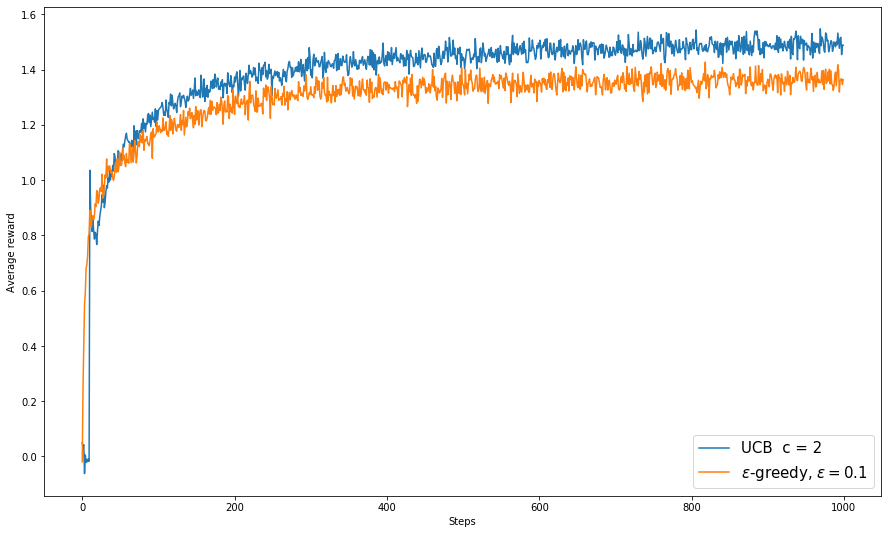

In [28]:
plt.figure(figsize = (15, 9))
plt.plot(data2[0], label = 'UCB  c = 2')
plt.plot(data2[1], label = (r'$\varepsilon$-greedy, $\varepsilon = ' + '0.1' + '$'))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend(loc = 'lower right', fontsize = 15)

plt.show()

# Simulation 4 : Gradient Bandit Algorithme

- In this last simulation we will play by four agents using different methods each with two parameters:
- 1st agent uses method with $\alpha$ = 0.1. and baseline = 0.
- 2sd agent uses method with $\alpha$ = 0.4 and baseline = 0.
- 3th agent uses method with $\alpha$ = 0.1. and baseline not null.
- 4th agent uses method with $\alpha$ = 0.4. and baseline not null.

In [16]:
def gradient_bandit_algorithm(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    return best_action_counts

In [17]:
data3 = gradient_bandit_algorithm()
data3

100%|██████████| 2000/2000 [03:23<00:00,  9.83it/s]


array([[0.099 , 0.1035, 0.094 , ..., 0.856 , 0.85  , 0.852 ],
       [0.089 , 0.093 , 0.1015, ..., 0.492 , 0.4905, 0.492 ],
       [0.0945, 0.106 , 0.117 , ..., 0.7375, 0.738 , 0.735 ],
       [0.091 , 0.1115, 0.1195, ..., 0.276 , 0.275 , 0.2745]])

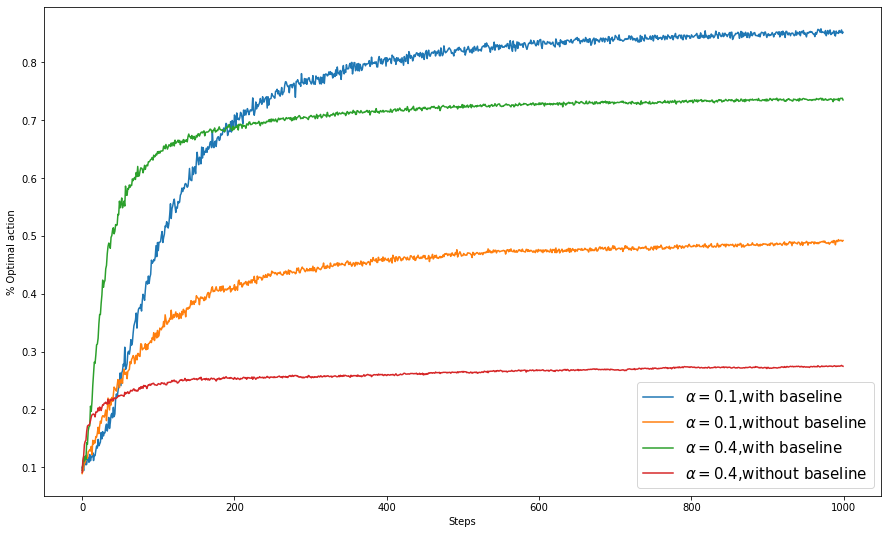

In [27]:
plt.figure(figsize = (15, 9))
labels = [r'$\alpha = ' + '0.1' + '$'   ',with baseline', r'$\alpha = ' + '0.1' + '$'   ',without baseline',
          r'$\alpha = ' + '0.4' + '$'   ',with baseline', r'$\alpha = ' + '0.4' + '$'   ',without baseline']

for i in range(4):
    plt.plot(data3[i], label=labels[i])
    
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend(loc = 'lower right', fontsize = 15)

plt.show()

# Reinforcement learning An introduction 

           Richard S.Sutton and Andrew G.Barto
           Chapitre 2 Multi-Armed-Bandit
